In [1]:
import numpy
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"]=[6,6]

In [4]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer()
X, y=data.data, data.target

In [5]:
X=data.data[:,:4]
X.shape

(569, 4)

In [6]:
from sklearn.preprocessing import StandardScaler
x_estandarizador=StandardScaler()
X_std=x_estandarizador.fit_transform(X)

In [7]:
x0=X_std[0]
y0=y[0]
print(x0,y0)

[ 1.09706398 -2.07333501  1.26993369  0.9843749 ] 0


In [8]:
#Se definene funciones de activacion distintas
#Funcion identidad: que se usa en la capa de entrada y no hace nada o sea(, f(x)=x)
#funcion Sigmoide: que aplica la funcion sigmoide f(x)=1/(1+e-{-x}) que convierte los numeros al rango [0, 1] y que se usa para problemas de clasificacion binaria

In [64]:
def fn_identidad(x, derivada=False):
    if derivada:
        return numpy.ones(x.shape)
    return x

def fn_sigmoide(x, derivada=False):
    if derivada:
        return x*(1-x)
    return 1/(1+numpy.exp(-x))

In [65]:
#Tambien se tiene que definir una manera de computar el error de predicccion (error, coste y perdida se usan indistintamente)

#PAra un problema de clasificacion binaria, una buena metrica es la perdida logaritmica (logloss)

In [182]:
def error_logloss(y_pred, y):
    p=numpy.clip(y_pred, 1e-15, 1- 1e-15)
    if y==1:
        return -numpy.log(p)
    else:
        return -numpy.log(1-p)

In [183]:
def error_logloss(y_pred, y):
    p=numpy.clip(y_pred, 1e-15, 1- 1e-15)
    return -numpy.log(p)*(y==1) - numpy.log(1-p)*(y==0)

In [184]:
class Layer:
    def __init__(self, n_unidades, fn_activacion, bias=True):
        self.n_unidades=n_unidades
        self.fn_activacion=fn_activacion
        self.dim_output=n_unidades

        #añadimos un peso para la unidad de bias
        self.bias=bias

        self.dimensiones="no generada"
        self.w=None

    def __repr__(self):
        return """
        Capa {}. dimensiones={}. 
        pesos: {}
        """.format(self.nombre, self.dimensiones, self.w)

    def generar_pesos(self, dim_ouput_anterior):
        if self.bias:
            self.dimensiones=(self.n_unidades, dim_ouput_anterior+1)
        else:
            self.dimensiones=(self.n_unidades, dim_ouput_anterior)
        self.w=numpy.random.random(self.dimensiones)

    def add_bias(self, x):
        if not self.bias:
            return x
        x_con_bias_1d=numpy.append(1, x)
        #append convierte en array 1dimensional necesitamos 2d
        return x_con_bias_1d.reshape(x_con_bias_1d.shape[0],1)

    def activar(self, x):
        x_con_bias_2d=self.add_bias(x)
        return self.fn_activacion(self.w @ x_con_bias_2d)

    def calcular_delta(self, producto_capa, output_capa):
        return producto_capa * self.fn_activacion(output_capa, derivada=True)

In [185]:
#Tenemos 3 tipos de capas de neuronas

#Capa de entrada: no hace nada, simplemente conecta el input con el resto de la red
#Capa ocuulta: tambien llama capa densa, realiza el algoritmo perceptron con una funcion de activacion no lineal
#Capa de salida: esta capa traduce el output de la capa antepenultima a la variable objetivo deseada

In [186]:
class InputLayer(Layer):
    nombre="entrada"

    def generar_pesos(self):
        pass

    def activar(self, x):
        return x

class HiddenLayer(Layer):
    nombre="oculta"

class OutLayer(Layer):
    nombre="salida"

In [203]:
class RedNeuronal:
    def __init__(self, ratio_aprend, fn_error):
        self.layers=[]
        self.ratio_aprend=ratio_aprend
        self.fn_error=fn_error

    def add_layer(self, layer):
        if layer.nombre=="entrada":
            layer.generar_pesos()
        else:
            layer.generar_pesos(self.layers[-1].dim_output)
        self.layers.append(layer)

    def __repr__(self):
        info_red=""
        for layer in self.layers:
            info_red += "\nCapa: {} N° unidades: {}".format(layer.nombre, layer.n_unidades)
        return info_red

    def forward(self, x):
        for layer in self.layers:
            layer.input=layer.add_bias(x).T
            x=layer.activar(x)
            layer.output=x
        return x

    def calcular_error_prediccion(self, y_pred, y):
        return self.fn_error(y_pred,y)

    def backward(self, y_pred, y):
        #El error de prediccion final
        delta_capa=self.calcular_error_prediccion(y_pred, y)
        for layer in reversed(self.layers):
            if layer.nombre == "entrada":
                continue
            if layer.nombre == "salida":
                self.delta_capa=delta_capa
                producto_capa=delta_capa @ layer.w
            else:
                #quitamos el error del bias de la capa anterior
                producto_capa=delta_capa[:,1:] @ layer.w
            delta_capa=layer.calcular_delta(producto_capa, layer.output)
            layer.delta=delta_capa
    
    def actualizar_pesos(self):
        """
        Actualiza pesos mediante el descenso de gradiente"""
        for layer in self.layers[1:]:
            layer.w=layer.w - self.ratio_aprend \
                *layer.delta * layer.input

    def aprendizaje(self, x, y):
        """
        Funcion principal para entrenar la red
        """
        y_pred=self.forward(x)
        self.backward(y_pred, y)
        self.actualizar_pesos()
        error_prediccion=self.calcular_error_prediccion(y_pred, y)
        return error_prediccion

    def predict_proba(self, x):
        return self.forward(x)

    def predict(self, x):
        probabilidad=self.forward(x)
        return (probabilidad>=0.5) 

In [204]:
#Creacion de la red nueronal
#En primer lugar tenemos que definir los tamaños de cada capa, y si van a incluir sesgo (bias) o no

In [205]:
n_input=4
n_oculta=5
n_output=1

ratio_aprendizaje=0.001
n_iteraciones=100

In [206]:
red_sigmoide=RedNeuronal(ratio_aprend=ratio_aprendizaje, fn_error=error_logloss)

red_sigmoide.add_layer(InputLayer(n_input, bias=False, fn_activacion=fn_identidad))
red_sigmoide.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_sigmoide))
red_sigmoide.add_layer(OutLayer(n_output, fn_activacion=fn_sigmoide))

In [207]:
#Ya se tiene un ared neuronal que aprende para optimizar una observacion usando el metodo del descenso de gradiente. Ahora solo tenemos que implementar el metodo de descenso estocastico de gradiente (SGD) para iterar en todo el dataset de entrenamiento e ir modificando los pesos para minimizar los errores de entrenamiento

In [211]:
def iteracion_sgd(red, X, y):
    #barajeamos los datos de entrenamiento
    indice_aleatorio=numpy.random.permutation(X.shape[0])
    error=[]
    #iteramos todo el dataset
    for i in range(indice_aleatorio.shape[0]):
        x0=X[indice_aleatorio[i]]
        y0=y[indice_aleatorio[i]]
        err=red.aprendizaje(x0, y0)
        error.append(err)
    return numpy.nanmean(numpy.array(error))

def entrenar_sgd(red, n_epocas, X, y):
    epocas=[]
    for epoca in range(n_epocas):
        error_epoca=iteracion_sgd(red, X, y)
        epocas.append([epoca, error_epoca])
    return numpy.array(epocas)

In [212]:
#ahora corremos el algoritmo durante varias iteraciones

In [213]:
resultados_sigmoide=entrenar_sgd(red_sigmoide, n_iteraciones, X_std, y)

Text(0, 0.5, 'Error medio')

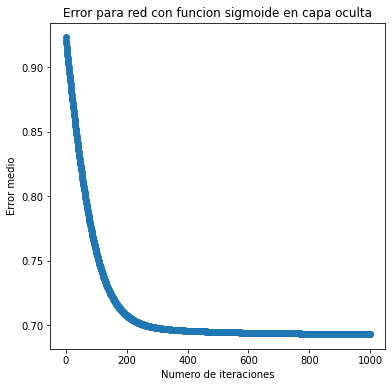

In [214]:
plt.scatter(x=resultados_sigmoide[:,0], y=resultados_sigmoide[:,1])
plt.title("Error para red con funcion sigmoide en capa oculta")
plt.xlabel("Numero de iteraciones")
plt.ylabel("Error medio")

In [216]:
#Lo bueno de las redes neuronales es que se tienen una flexibilidad que otros modelos no tienen
#Por ejemplo podemos cambiar la funcion de activacion de la capa oculta
#En la practica la funcion sigmoide no se usa para capas ocultas, se suele usar mas la Unidad Linear Rectificada (ReLu)

In [217]:
def fn_relu(x, derivada=False):
    if derivada:
        return 1. * (x>0.)
    return numpy.maximum(x, 0.)

def fn_leakyrelu(x, derivada=False):
    if derivada:
        if x.any()>0:
            return 1.
        else:
            return 0.01
    return numpy.maximum(x, 0.01*x)

In [218]:
red_relu=RedNeuronal(ratio_aprend=ratio_aprendizaje, fn_error=error_logloss)
red_relu.add_layer(InoutLayer(n_input, bias=False, fn_activacion=fn_identidad))
red_relu.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_relu))
red_relu.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_relu))
red_relu.add_layer(OutLayer(n_output, fn_activacion=fn_sigmoide))

In [219]:
resultados_relu=entrenar_sgd(red_relu, n_iteraciones, X_std, y)

Text(0.5, 1.0, 'Error para red con funcion ReLu en capa oculta')

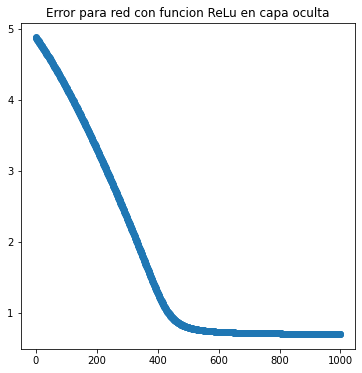

In [220]:
plt.scatter(x=resultados_relu[:,0], y=resultados_relu[:,1])
plt.title("Error para red con funcion ReLu en capa oculta")

In [226]:
print(resultados_sigmoide[-1:,1])
print(resultados_relu[-1:,1])

[0.69332491]
[0.70206402]
